In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [3]:
import os
import numpy as np

import pandas as pd
import cudf as gd

from cuml.manifold.umap import UMAP as cumlUMAP

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

In [6]:
DATASET_ID = 'mouse_usv_long'

In [7]:
window_length_ms = 5
hop_length_ms = 1
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

5

In [108]:
mouse = '832'

### load data

In [128]:
windows_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_windows_' + str(window_length_ms)+'.npy')
windows  = np.load(windows_loc.as_posix())
np.shape(windows)

(141032, 160)

In [129]:
spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_spec.npy')
spec_large  = np.load(spec_loc.as_posix())
np.shape(spec_large)

(820, 141036)

In [130]:
spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_spec_small.npy')
spec  = np.load(spec_loc.as_posix())
np.shape(spec)

(32, 141036)

In [131]:
onsets_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_onsets_offsets.npy')
onsets, offsets  = np.load(onsets_loc.as_posix())
np.shape(onsets), np.shape(offsets)

((621,), (621,))

In [132]:
excess = (np.shape(spec)[1] - len(windows))
excess

4

In [133]:
#spec = spec[:, (int(np.ceil(excess/2))):-int(np.floor(excess/2))]
spec = spec[:, :-int(excess)]

In [134]:
np.shape(spec)

(32, 141032)

In [135]:
mouse = '832_1'

windows_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_windows_' + str(window_length_ms)+'.npy')
windows2  = np.load(windows_loc.as_posix())
np.shape(windows)

spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_spec.npy')
spec_large2  = np.load(spec_loc.as_posix())
np.shape(spec_large)

spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_spec_small.npy')
spec2  = np.load(spec_loc.as_posix())
np.shape(spec)

onsets_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_onsets_offsets.npy')
onsets2, offsets2  = np.load(onsets_loc.as_posix())
np.shape(onsets), np.shape(offsets)

excess2 = (np.shape(spec2)[1] - len(windows2))
excess2

#spec = spec[:, (int(np.ceil(excess/2))):-int(np.floor(excess/2))]
spec2 = spec2[:, :-int(excess2)]

In [136]:
windows = np.vstack([windows, windows2])

In [137]:
spec_large = np.hstack([spec_large2, spec_large2])

In [138]:
spec = np.hstack([spec, spec2])

In [139]:
onsets2 += 104799 / 1000
offsets2 += 104799 / 1000

In [140]:
onsets = np.concatenate([onsets, onsets2])

In [141]:
offsets = np.concatenate([offsets, offsets2])

In [142]:
len(offsets)

1242

In [144]:
np.shape(spec), len(windows)

((32, 282064), 282064)

### plot spec

In [89]:
rate = 250000

In [90]:
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

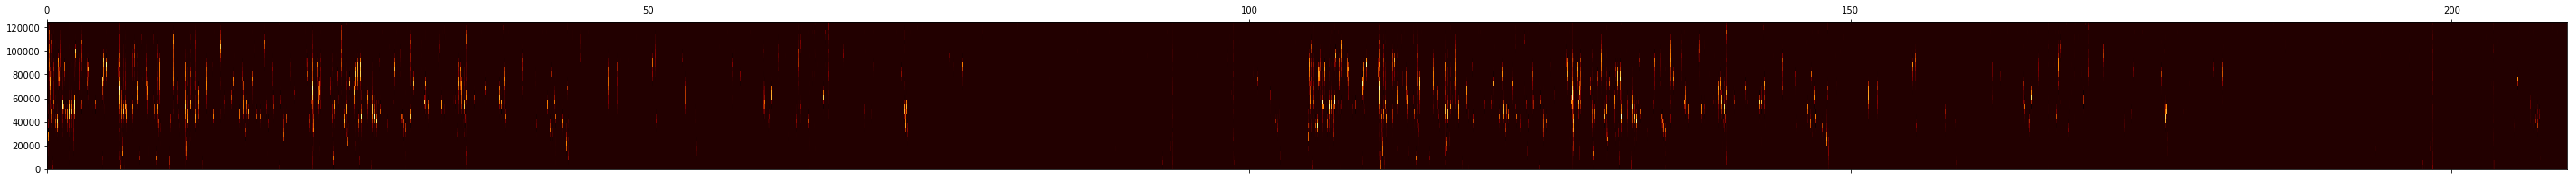

In [91]:
fig, ax = plt.subplots(figsize=(50,3))
plot_spec(spec, fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
plt.show()

In [92]:
from avgn.visualization.spectrogram import draw_spec_set

In [93]:
segs = [
    spec[:, int(onset * 1000 / hop_length_ms) : int(offset * 1000 / hop_length_ms)]
    for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets)))
]
#segs = [norm(i) for i in segs if np.prod(np.shape(i)) > 0]

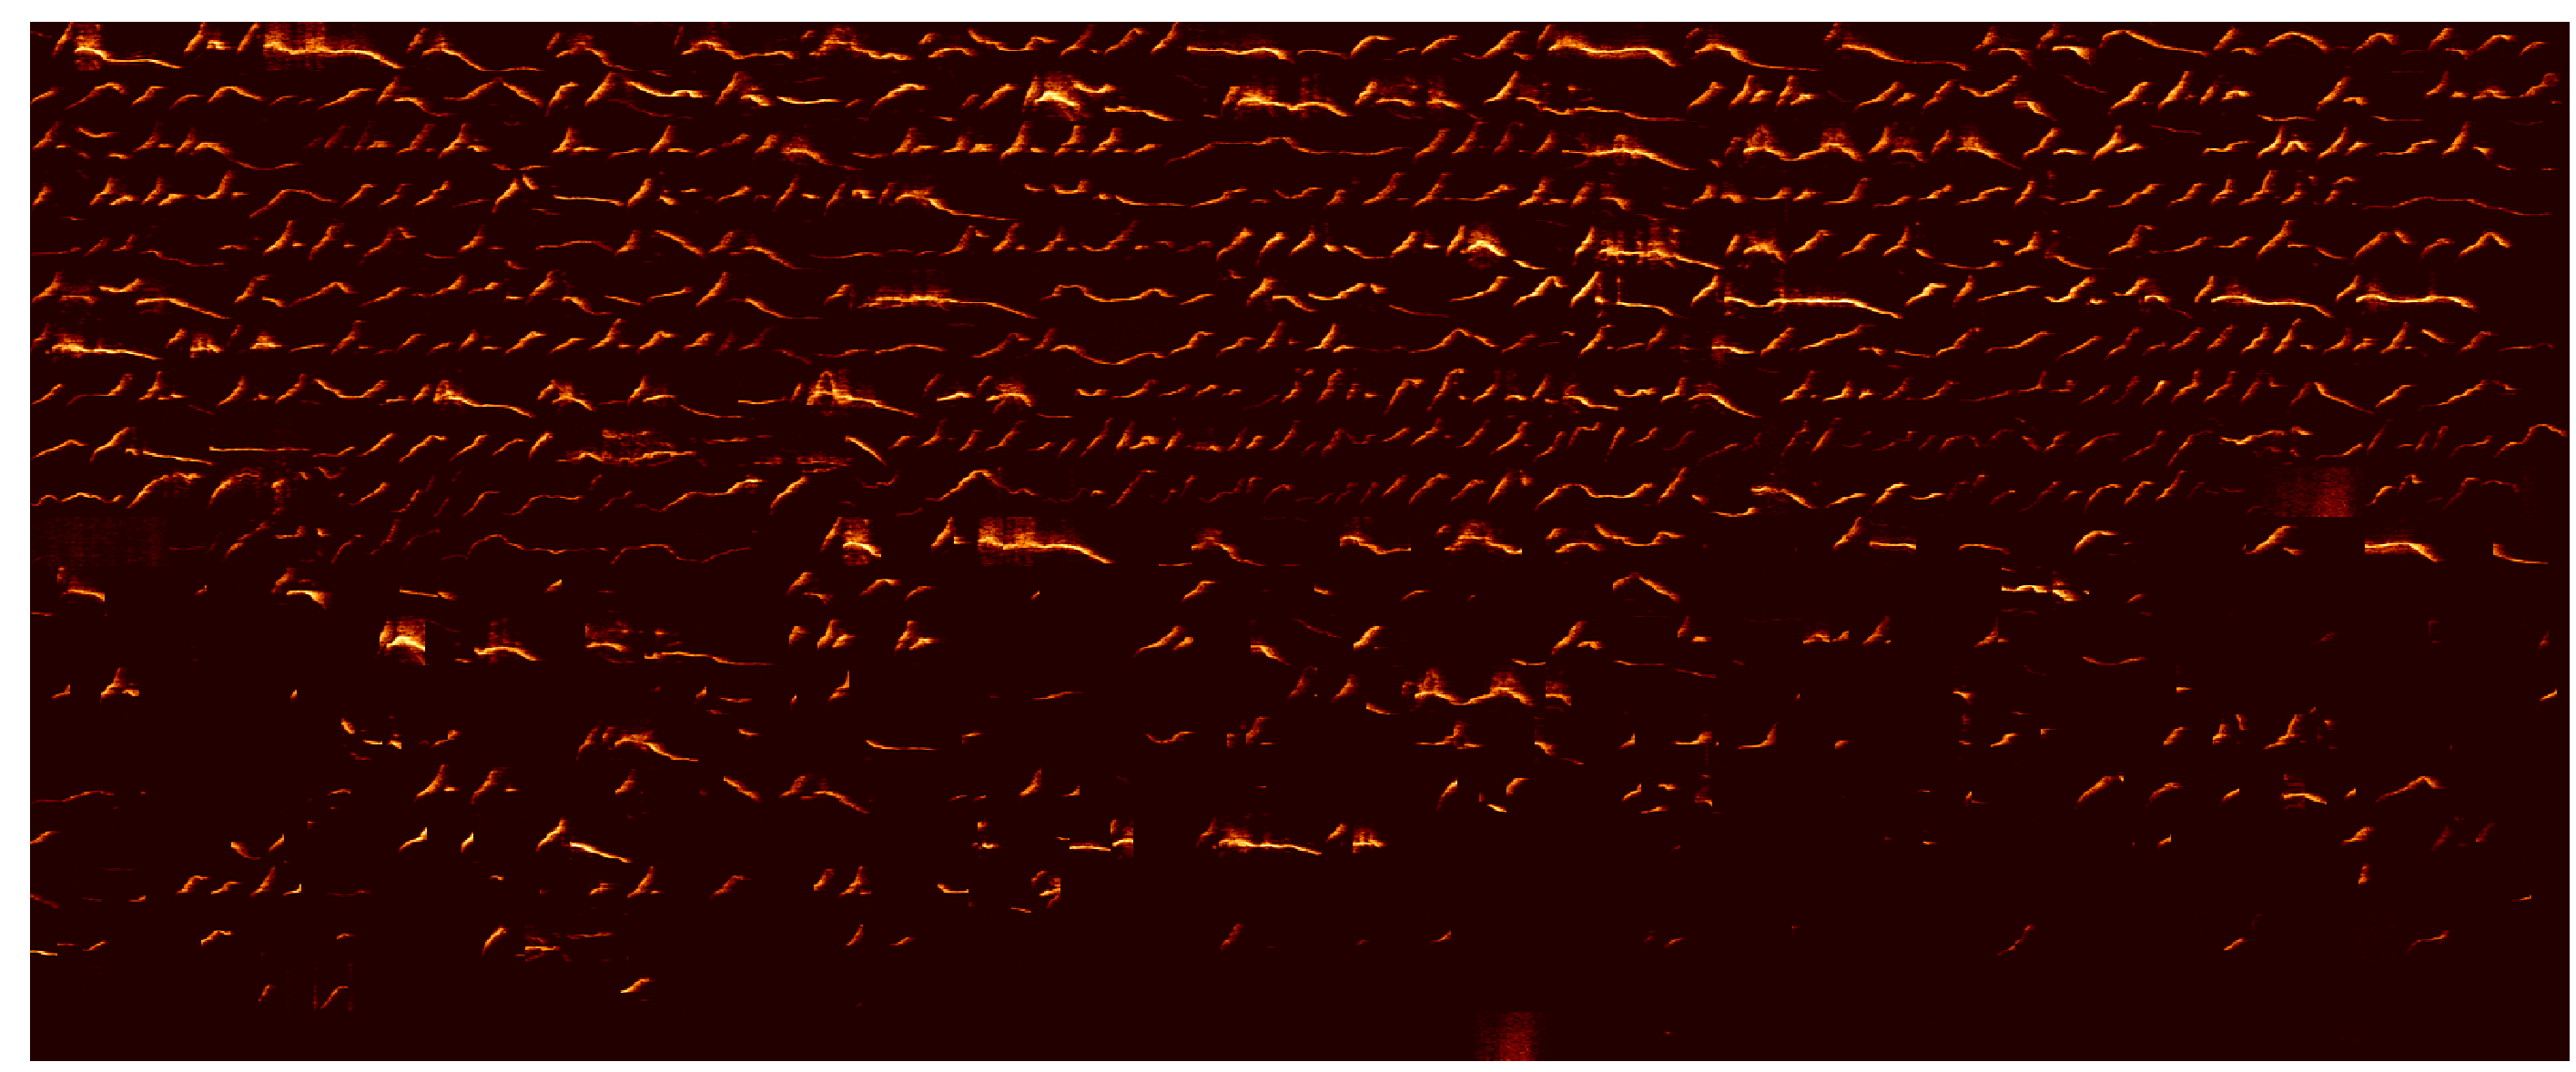

In [94]:
draw_spec_set(segs, zoom=1, maxrows=60, colsize=50)

### create embedding

In [95]:
cuml_umap = cumlUMAP(min_dist = 0.5)
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [97]:
np.shape(embedding), np.min(embedding, axis=0), np.max(embedding, axis=0)

((245827, 2),
 array([-10905.89746094, -45446.01953125]),
 array([19599.48632812, 14694.00683594]))

(-15, 15)

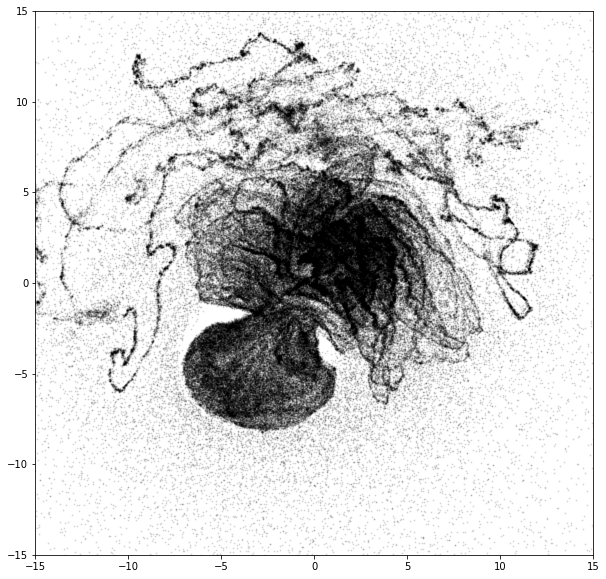

In [98]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.1, s = 1, color='k')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [99]:
from avgn.utils.paths import FIGURE_DIR,ensure_dir
from avgn.utils.general import save_fig

In [100]:
ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)

### create power-mask for sequences

In [153]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [154]:
mask = np.expand_dims(norm(np.max(spec, axis=0)),1)
mask = (mask+1e-5)**1

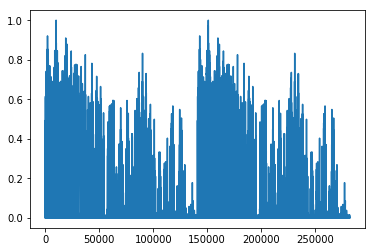

In [155]:
plt.plot(mask)

### plot seqs

In [156]:
xlims = [-10, 10]
ylims = [-10, 10]

In [157]:
np.shape(mask)

(282064, 1)

In [158]:
import copy

In [159]:
np.shape(embedding)

(245827, 2)

In [163]:
len(cols)

245827

In [164]:
len(mask)

282064

ValueError: operands could not be broadcast together with shapes (245827,3) (282064,1) 

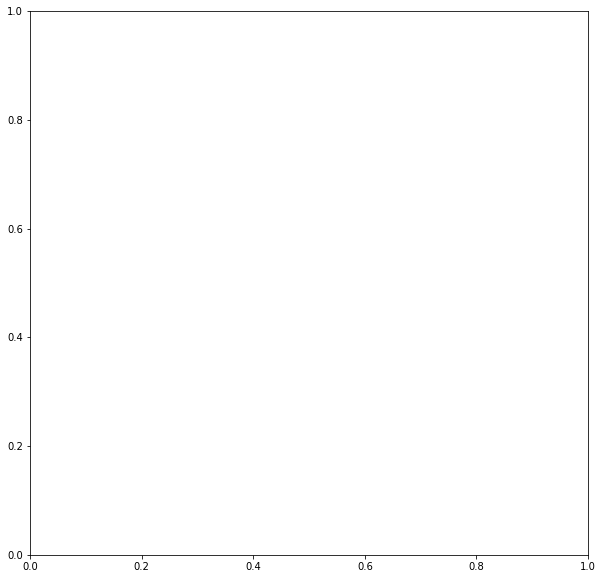

In [162]:
window_z = copy.deepcopy(embedding)
fig, ax = plt.subplots(figsize=(10,10))
curr_idx = 0
cols = np.array(sns.color_palette('hls', len(window_z)))
cols = 1-((1-cols) * mask) #+ (add*(mask))
ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 1, c= cols)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
#ax.axis('off')

#save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('umap_seqs_single_'+key), save_png=True)

### plot segments individually

(0.0, 10.0, -7.0, 4.0)

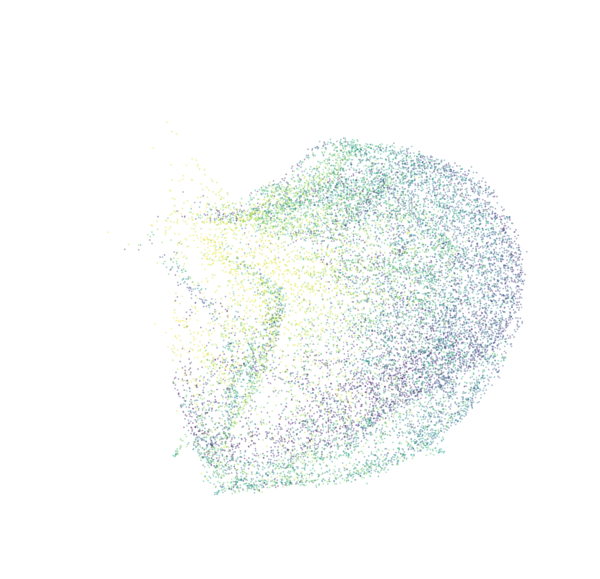

In [75]:
fig, ax = plt.subplots(figsize=(10,10))

for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    cols = np.array(sns.color_palette('viridis', len(window_z)))
    ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.25, s = 1, c= cols)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

(0.0, 10.0, -7.0, 4.0)

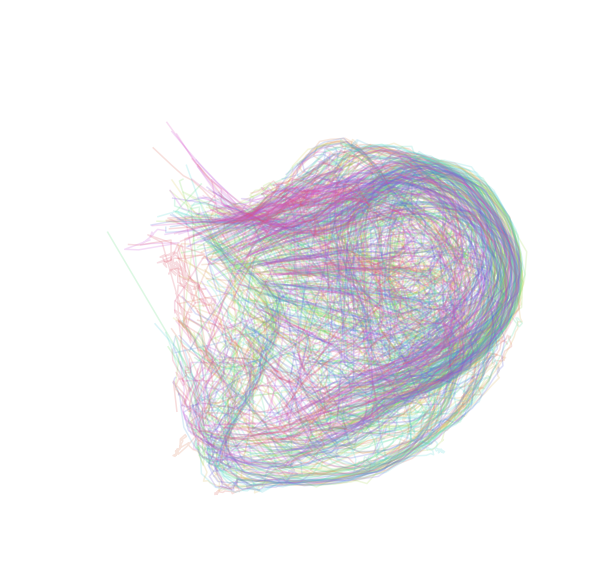

In [77]:
cols = np.array(sns.color_palette('hls', len(onsets)))
fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    col = cols[oi]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.2, color= col)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

In [72]:
from avgn.visualization.projections import scatter_spec

In [73]:
windows_reshaped = np.reshape(
    windows,
    (len(windows), window_length_frames, int(np.shape(windows)[1] / window_length_frames)),
)

In [74]:
windows_reshaped = np.swapaxes(windows_reshaped, 1,2)

(-9.0, 5.0, -5.0, 5.0)

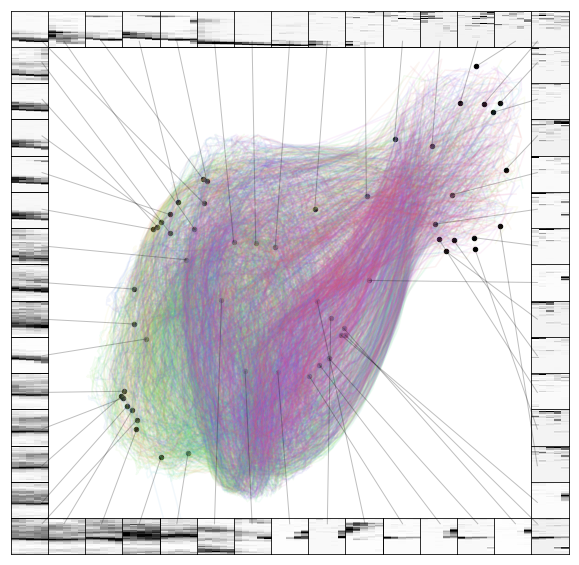

In [153]:
nex = -1
fig, axs, main_ax = scatter_spec(
    embedding[:nex],
    windows_reshaped[:nex],
    column_size=15,
    x_range = xlims,
    y_range = ylims,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        #'labels': subset_df.labels.values[:nex],
        'alpha':0.05,
        's': 1,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    show_scatter=False
);
#save_fig(FIGURE_DIR / 'phonemes', dpi=300, save_jpg=True)

# color = location in sequence
cols = np.array(sns.color_palette('hls', len(onsets)))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    col = cols[oi]
    main_ax.plot(window_z[:,0], window_z[:,1], alpha = 0.075, color= col)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

In [76]:
from avgn.visualization.projections import colorline

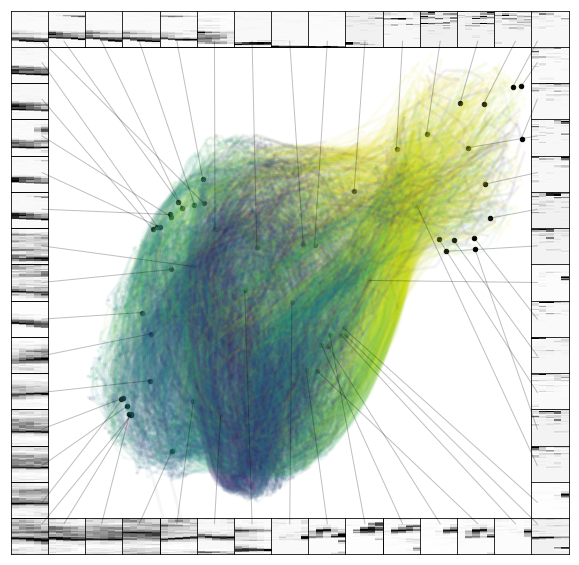

In [297]:
fig, axs, main_ax = scatter_spec(
    embedding[:nex],
    windows_reshaped[:nex],
    column_size=15,
    x_range = xlims,
    y_range = ylims,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        #'labels': subset_df.labels.values[:nex],
        'alpha':0.05,
        's': 1,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    show_scatter=False
);

# color = time
#fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    colorline(window_z[:,0], window_z[:,1], alpha = 0.05, ax = main_ax, cmap=plt.cm.viridis)
    #if oi == 10:
    #    break


(-9.0, 5.0, -5.0, 5.0)

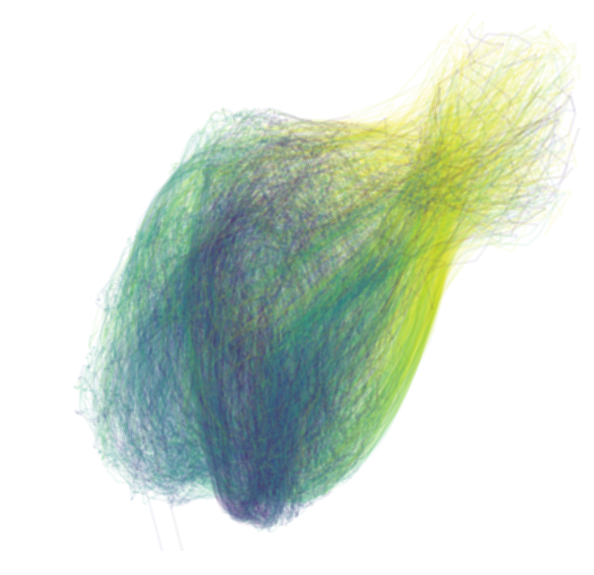

In [77]:
# color = time
fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    colorline(window_z[:,0], window_z[:,1], alpha = 0.05, ax = ax, cmap=plt.cm.viridis)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

(-9.0, 5.0, -5.0, 5.0)

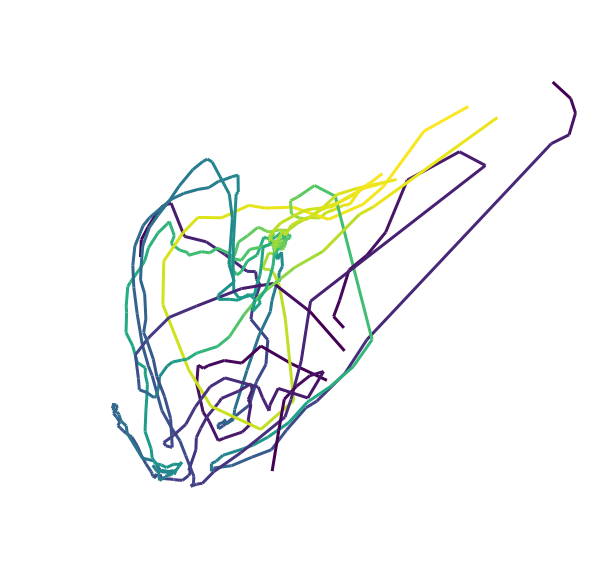

In [93]:
cols = sns.color_palette('Set1', 12)
fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    col = cols[oi]
    #ax.plot(window_z[:,0], window_z[:,1], alpha = 1, color= col)
    colorline(window_z[:,0], window_z[:,1], alpha = 1, ax = ax, cmap=plt.cm.viridis)
    if oi == 5:
        break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

(-9.0, 5.0, -5.0, 5.0)

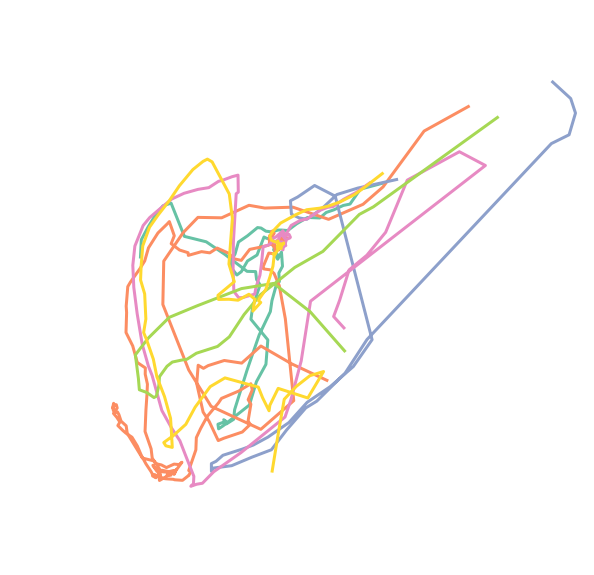

In [95]:
cols = sns.color_palette('Set2', 12)
fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    col = cols[oi]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 1, color= col, lw=3)
    #colorline(window_z[:,0], window_z[:,1], alpha = 1, ax = ax, cmap=plt.cm.viridis)
    if oi == 5:
        break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

### plot specs with colorspace

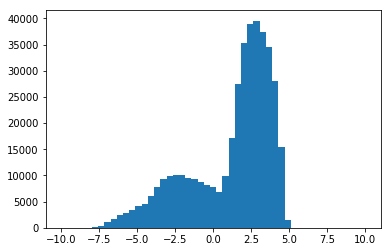

In [78]:
import copy

z_normed = copy.deepcopy(embedding)
plt.hist(z_normed.flatten(), bins = np.linspace(-10,10, 50));
z_normed[:,0][z_normed[:,0] > xlims[1]] = xlims[1]
z_normed[:,0][z_normed[:,0] < xlims[0]] = xlims[0]
z_normed[:,1][z_normed[:,1] > ylims[1]] = ylims[1]
z_normed[:,1][z_normed[:,1] < ylims[0]] = ylims[0]

z_normed[:,0] = norm(z_normed[:,0])
z_normed[:,1] = norm(z_normed[:,1])

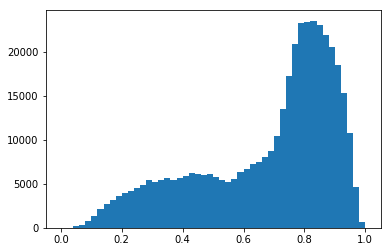

In [79]:
plt.hist(z_normed.flatten(), bins=50);

In [80]:
from matplotlib import gridspec
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

In [81]:
window_z = z_normed
R = 1-norm(window_z[:,0])#*.75 + .25
G = 1-norm(window_z[:,1])#*.75 + .25
B = np.ones_like(G)*.5
RGB = np.dstack((R,G,B))
RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
rgb_img = np.expand_dims(RGB,0)

In [97]:
np.shape(rgb_img)

(1, 204630, 3)

In [82]:
rgb_img_masked = ((rgb_img) * mask**.25)

In [83]:
start_samp = 7000
end_samp = 8000

In [269]:
import matplotlib.patches as patches

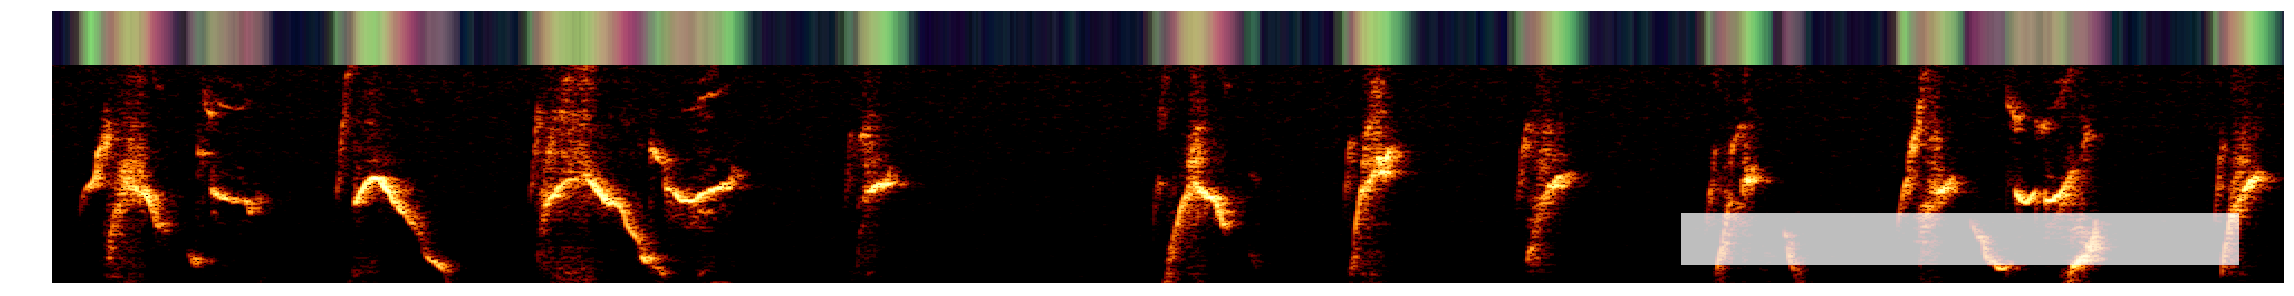

In [293]:
fig = plt.figure(figsize=(40,5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], wspace=0, hspace=0) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.imshow(rgb_img_masked[:,start_samp:end_samp,:], interpolation=None, aspect='auto')
#ax0.imshow(rgb_img[:,start_samp:end_samp,:], interpolation=None, aspect='auto')
plot_spec(spec_large[:,start_samp:end_samp], fig, ax1, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
ax0.axis('off')
ax1.axis('off')
ax0.set_axis_off()
ax1.set_axis_off()

rect = patches.Rectangle((0.73,10000),0.25,30000,facecolor='white', alpha = 0.75)
ax1.add_patch(rect)


In [265]:
start_samp = 8000
end_samp = 9000

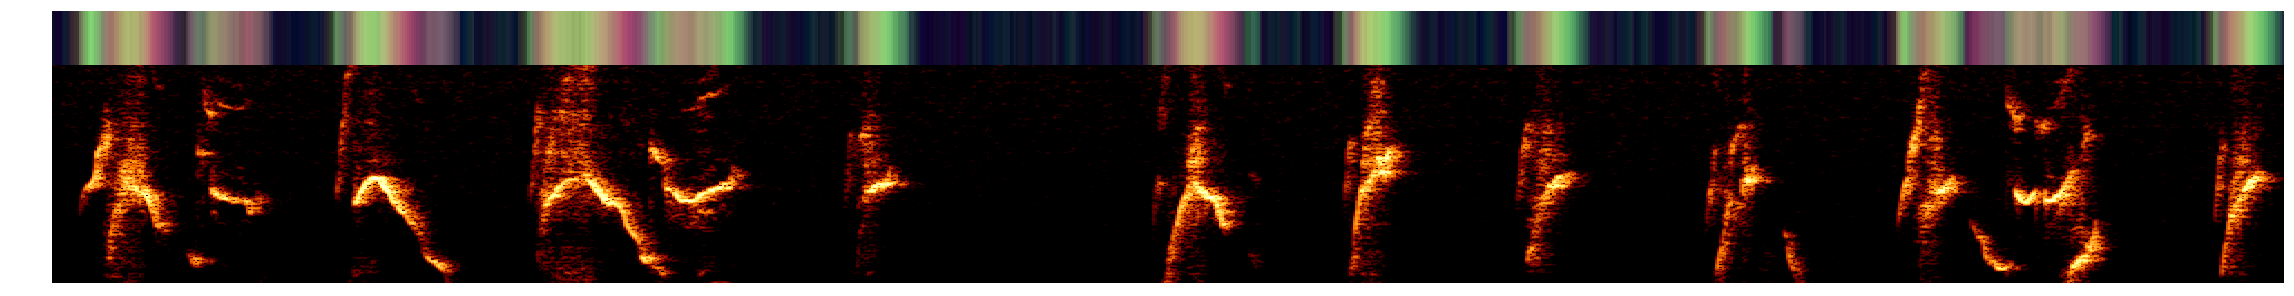

In [266]:
fig = plt.figure(figsize=(40,5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], wspace=0, hspace=0) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.imshow(rgb_img_masked[:,start_samp:end_samp,:], interpolation=None, aspect='auto')
#ax0.imshow(rgb_img[:,start_samp:end_samp,:], interpolation=None, aspect='auto')
plot_spec(spec_large[:,start_samp:end_samp], fig, ax1, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
#ax0.axis('off')
#ax1.axis('off')
ax0.set_axis_off()
ax1.set_axis_off()


### sort syllables by similarity

In [96]:
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

In [99]:
syllable_cols = [
    np.squeeze(rgb_img_masked[:, int(onset * 1000 / hop_length_ms) : int(offset * 1000 / hop_length_ms), :])
    for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets)))
]

(array([111., 130., 130., 126.,  95., 148., 155., 140., 104.,  44.,  48.,
         30.,  23.,  16.,  18.,  18.,  21.,  19.,  12.,  18.,  25.,  30.,
         13.,  12.,  18.,   8.,   9.,   6.,   9.,   3.,   8.,   7.,   5.,
          8.,   3.,   4.,   2.,   1.,   3.,   3.,   1.,   1.,   1.,   0.,
          1.,   0.,   1.,   1.,   0.,   1.]),
 array([ 10.  ,  13.78,  17.56,  21.34,  25.12,  28.9 ,  32.68,  36.46,
         40.24,  44.02,  47.8 ,  51.58,  55.36,  59.14,  62.92,  66.7 ,
         70.48,  74.26,  78.04,  81.82,  85.6 ,  89.38,  93.16,  96.94,
        100.72, 104.5 , 108.28, 112.06, 115.84, 119.62, 123.4 , 127.18,
        130.96, 134.74, 138.52, 142.3 , 146.08, 149.86, 153.64, 157.42,
        161.2 , 164.98, 168.76, 172.54, 176.32, 180.1 , 183.88, 187.66,
        191.44, 195.22, 199.  ]),
 <a list of 50 Patch objects>)

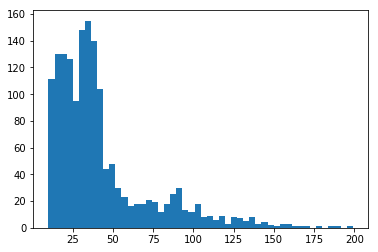

In [102]:
syll_col_lens = [len(i) for i in syllable_cols]
plt.hist(syll_col_lens, bins=50)

In [154]:
syll_mat_full = np.zeros((len(syll_col_lens),np.max(syll_col_lens),3))
for si, i in enumerate(tqdm(syllable_cols)):
    syll_mat_full[si,:len(i), :] = i

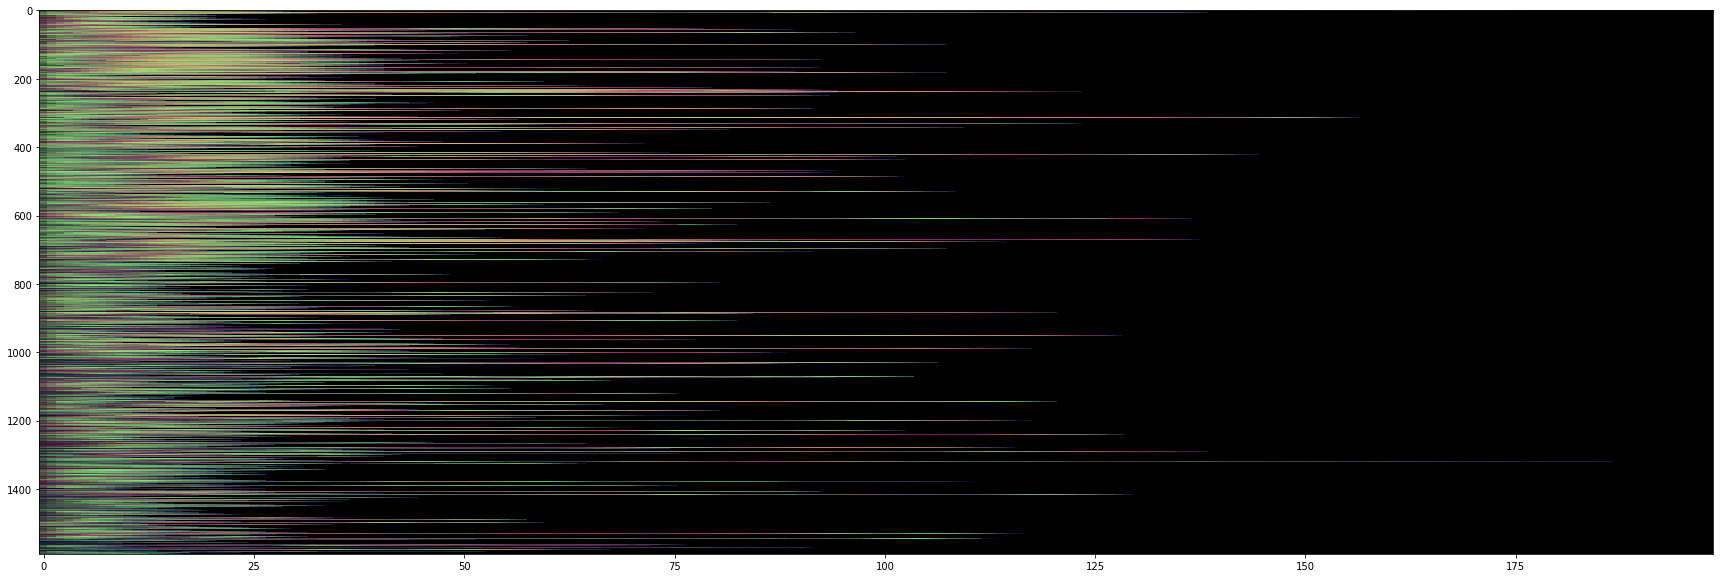

In [155]:
fig, ax = plt.subplots(figsize=(30,10))
ax.imshow(syll_mat_full, interpolation=None, aspect='auto')

In [156]:
syll_mat = syll_mat_full[:,:50,:]

In [157]:
syll_flat = syll_mat.reshape((len(syll_mat), np.prod(np.shape(syll_mat)[1:])))
np.shape(syll_flat)

(1590, 150)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


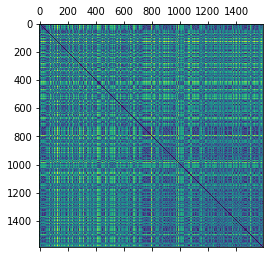

In [158]:
dists = distance_matrix(syll_flat, syll_flat)
# hierarchical clustering
linkage_matrix = linkage(dists, "single")
plt.matshow(dists)

In [159]:
dn = dendrogram(
    linkage_matrix,
    p=6,
    truncate_mode="none",
    get_leaves=True,
    orientation="left",
    no_labels=True,
    link_color_func=lambda k: "k",
    show_contracted=False,
    no_plot=True
)

### Correlation plots

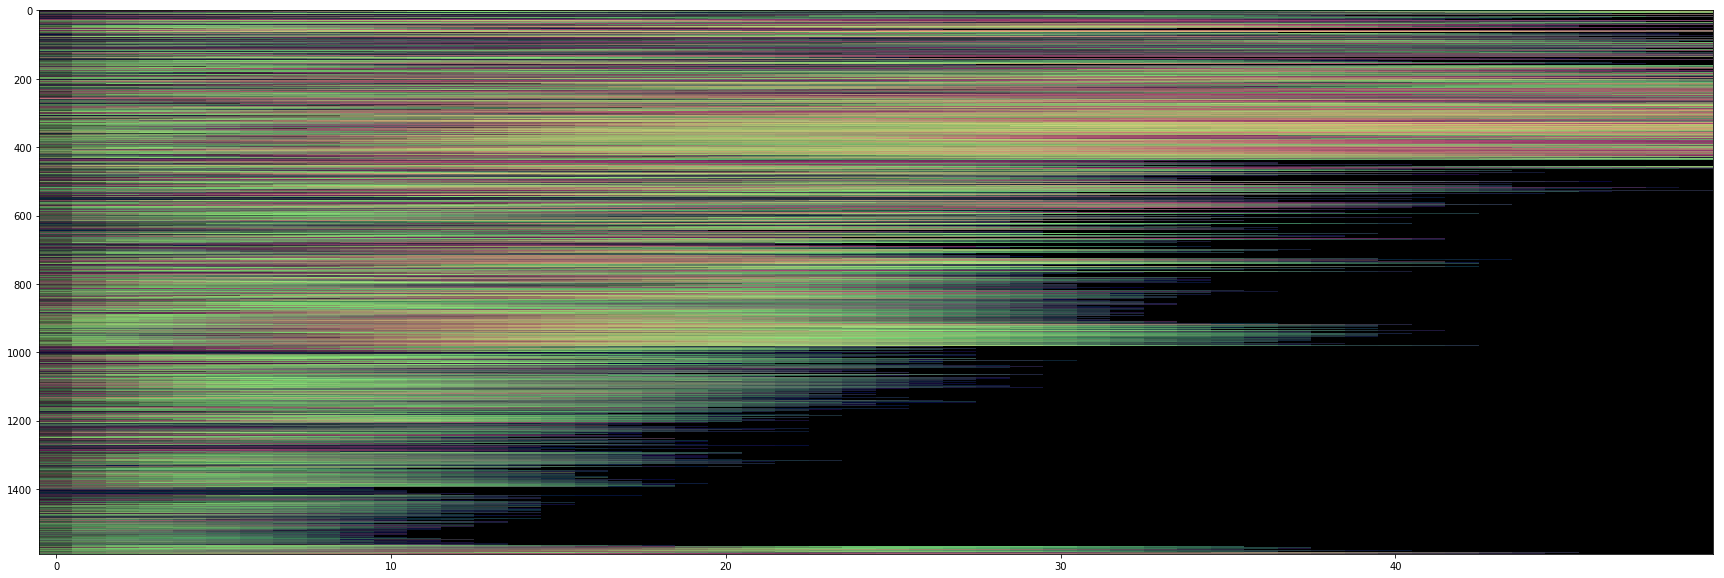

In [160]:
shifted_syll_mat = [syll_mat[leaf] for li, leaf in enumerate(dn['leaves'])]
fig, ax = plt.subplots(figsize=(30,10))
ax.imshow(shifted_syll_mat, interpolation=None, aspect='auto')
#ax.set_xlim([0,100])

In [161]:
cuml_umap2 = cumlUMAP(min_dist = 0.5)
embedding2 = cuml_umap.fit_transform(syll_flat)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


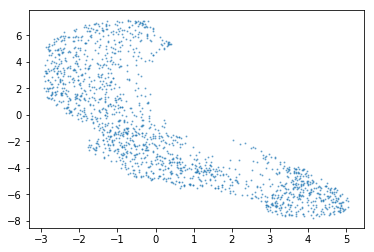

In [186]:
plt.scatter(embedding2[:,0], embedding2[:,1], alpha=0.5, s=1)

In [162]:
np.shape(embedding2)

(1590, 2)

In [163]:
segs_sorted = [segs[i] for i in dn['leaves']]

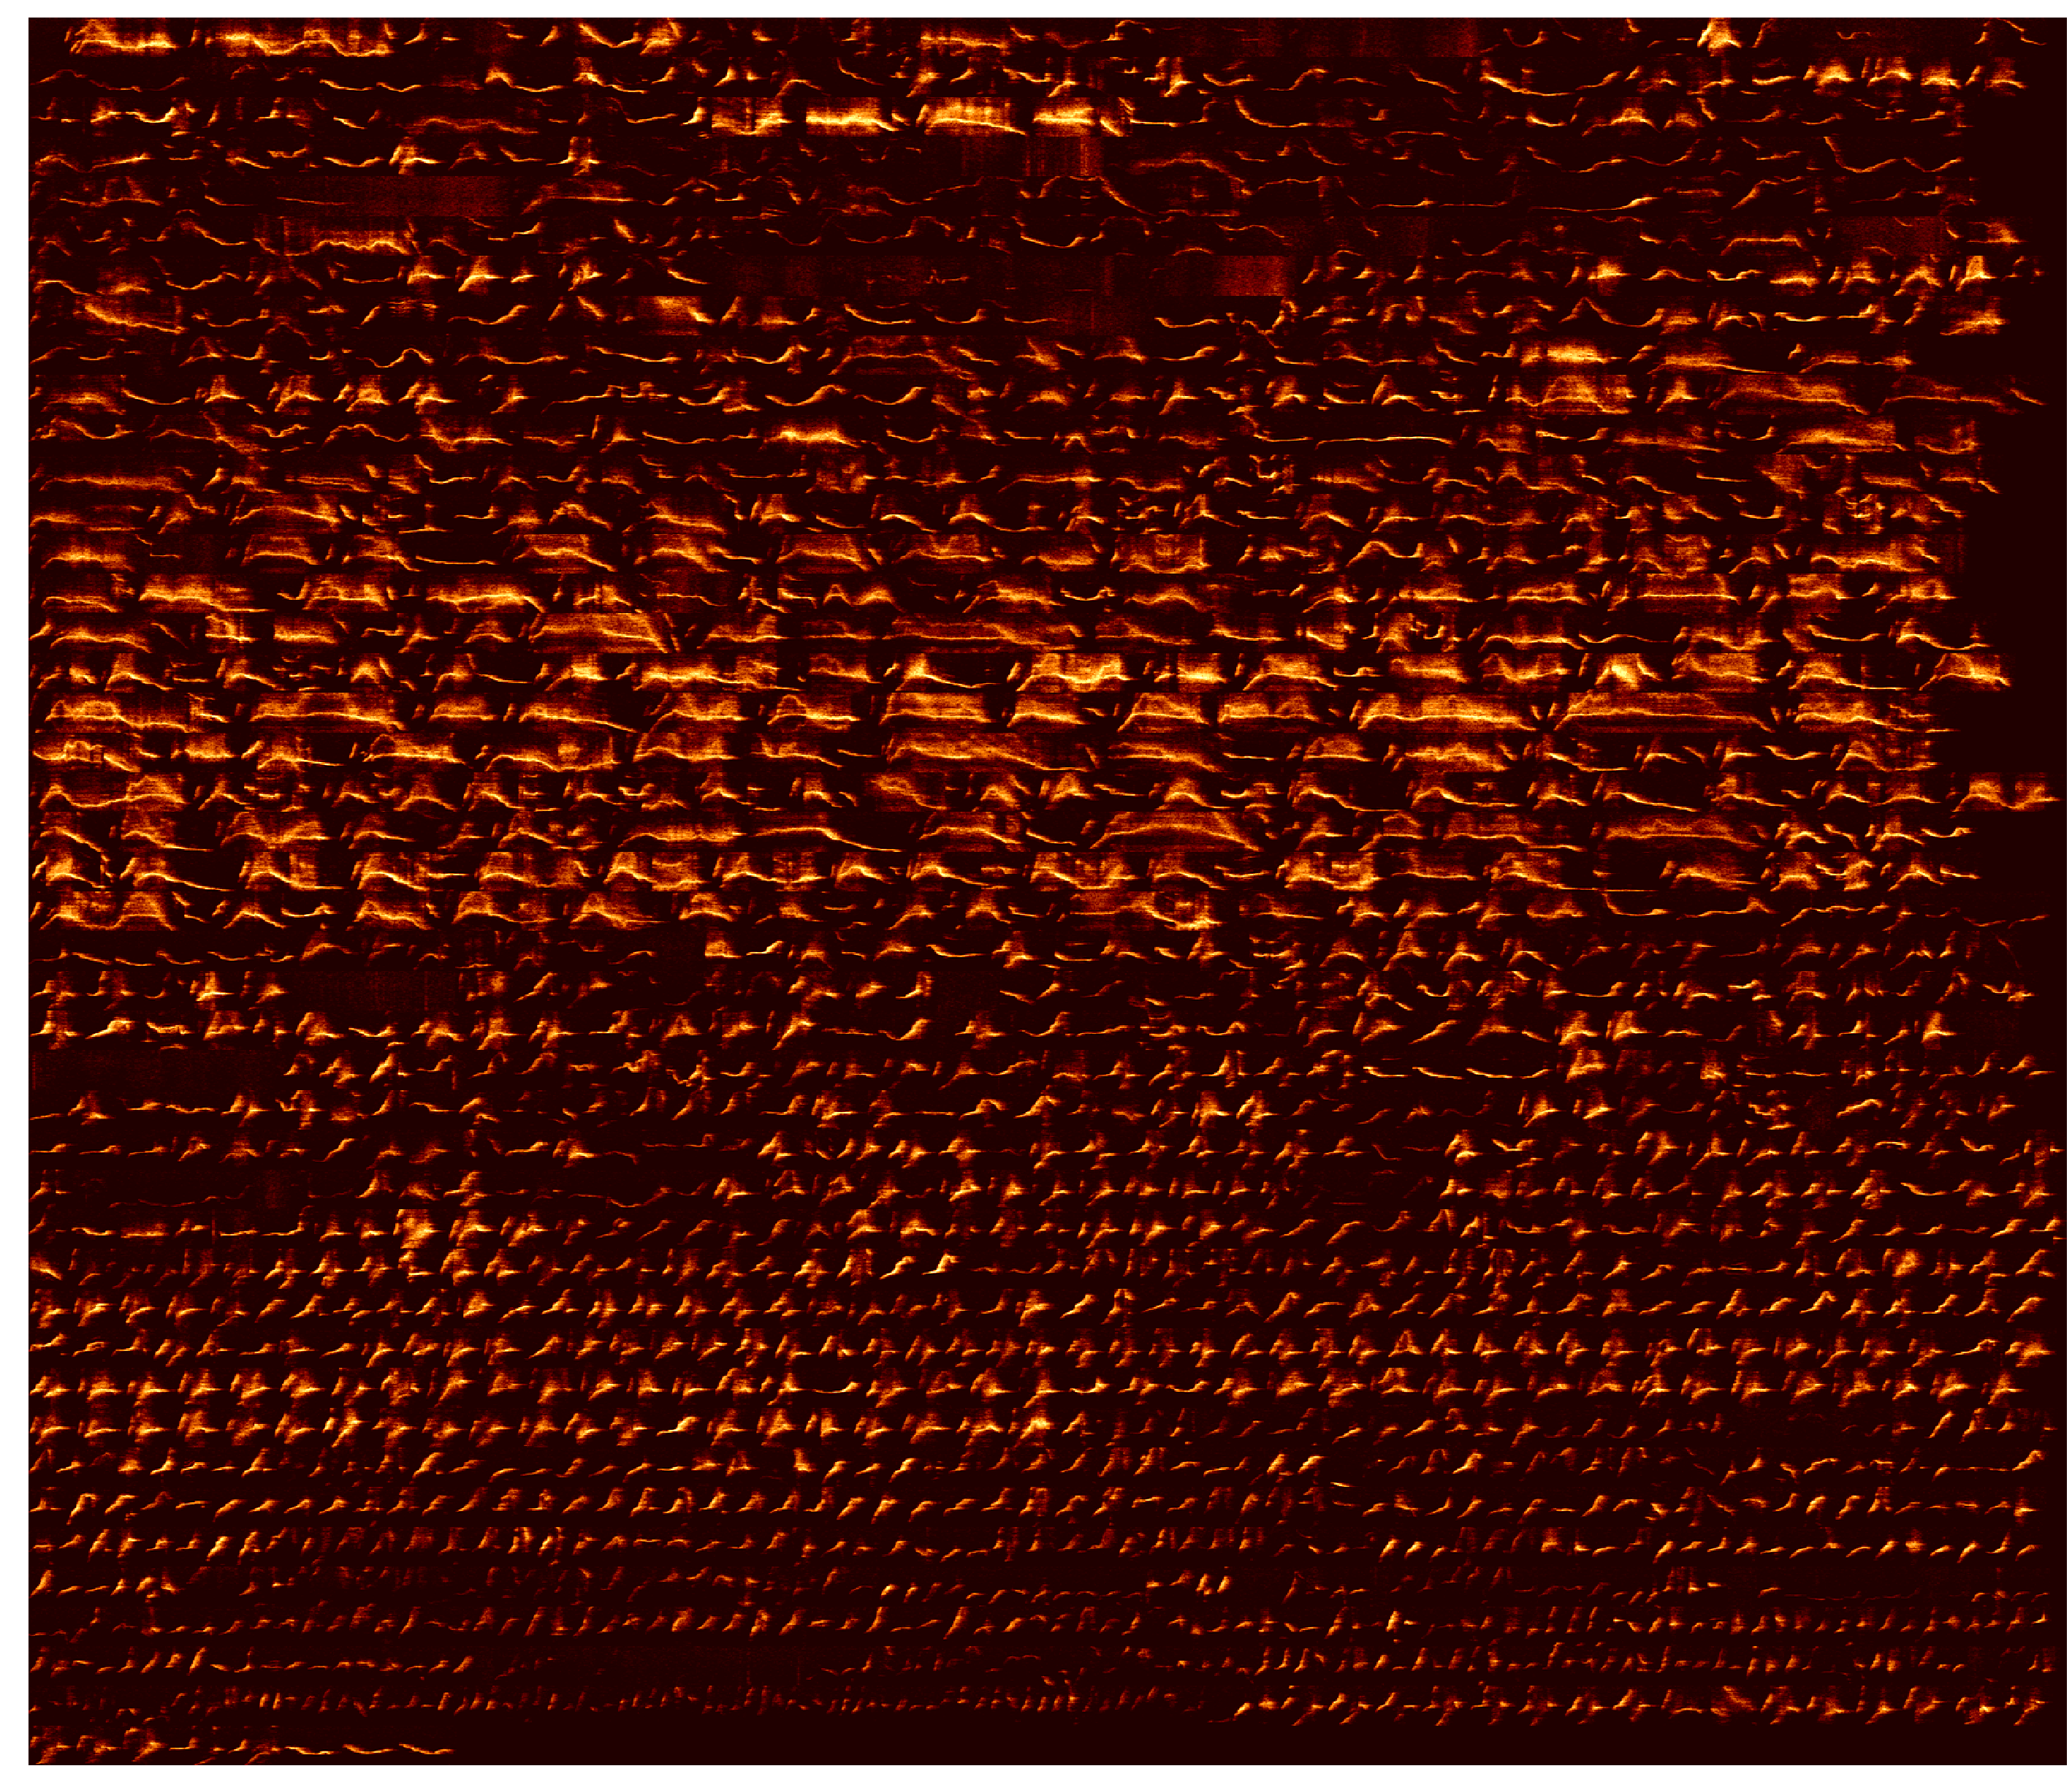

In [164]:
draw_spec_set(segs_sorted, zoom=1, maxrows=60, colsize=50)#, cmap = plt.cm.Greys)

In [165]:
syll_flat_sorted = [syll_flat[i] for i in dn['leaves']]

In [166]:
dists = distance_matrix(syll_flat_sorted, syll_flat_sorted)
# hierarchical clustering
linkage_matrix = linkage(dists, "single")


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.5, 1589.5, 1589.5, -0.5)

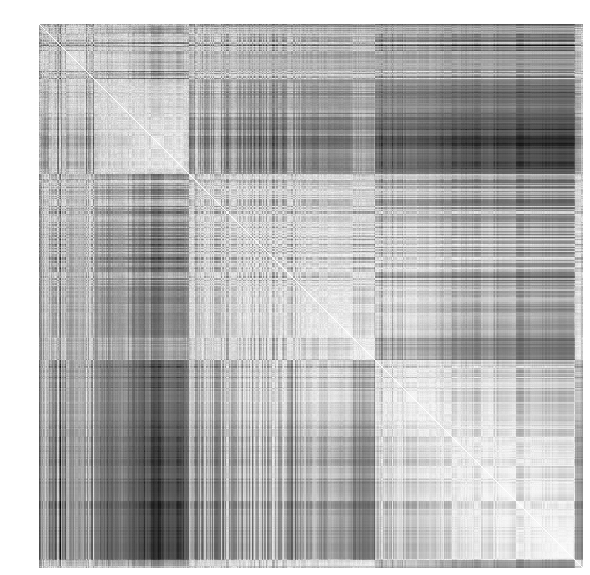

In [168]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(dists, cmap=plt.cm.Greys)
ax.axis('off')

### Plot over time

In [180]:
np.shape(embedding)

(204630, 2)

In [262]:
cols = {leaf: col for leaf, col in zip(dn['leaves'],sns.color_palette('hls', len(dn['leaves'])))}
col_plot = np.ones((len(embedding), 3))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    col_plot[int(onset * 1000 / hop_length_ms) : int(offset * 1000 / hop_length_ms), :] = cols[oi]
col_plot = col_plot[::10]
col_plot = np.expand_dims(col_plot, 0)

l = 400
col_plot = np.vstack([col_plot[:,l*i:l*(i+1),:] for i in range(int(np.floor(np.shape(col_plot)[1] / l)))])
np.shape(col_plot)

(51, 400, 3)

(-0.5, 399.5, 50.5, -0.5)

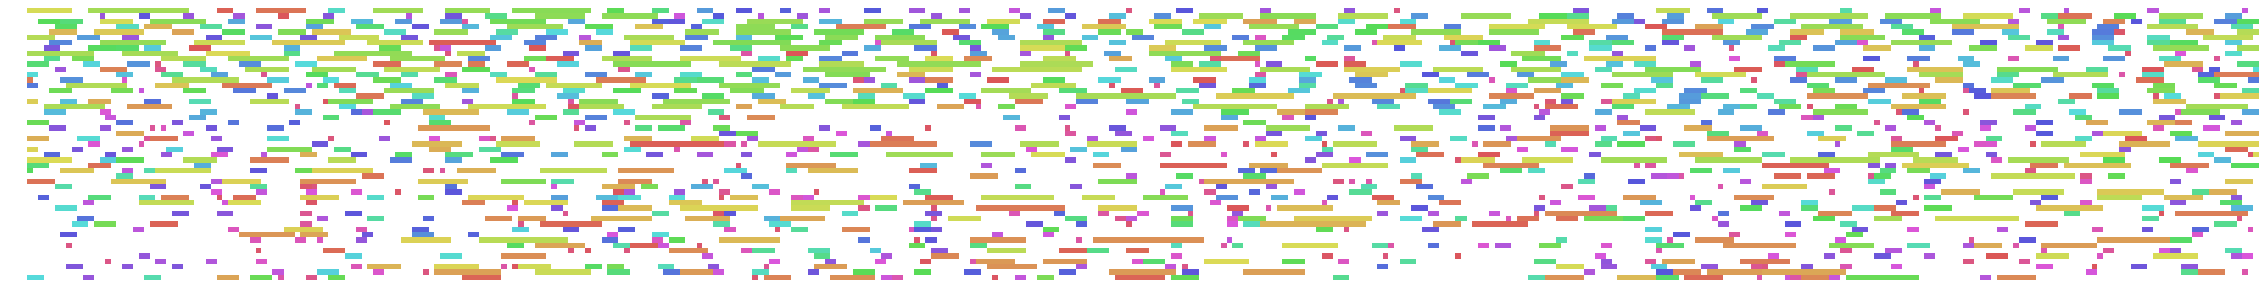

In [264]:
fig, ax = plt.subplots(figsize=(40,5))
ax.imshow(col_plot[:,:100000,:],  interpolation=None, aspect='auto')
ax.axis('off')